# Heymans example workflow for Brightspace

This notebook provides an example workflow for using Heymans as a Python library to grade open-ended exams in combination with the Brightspace learning environment.

Sebastiaan Mathôt and Wouter Kruijne

Faculty of Behavioral and Social Sciences, University of Groningen, Netherlands

- <https://github.com/rug-gmw/heymans>

## Getting started

Import relevant libraries and specify model. Ideally, you set API keys through environment variables. You can also specify your API directly in the code below. Make sure that you do not accidentally make your API key publicly available though!

You can install Heymans and all dependencies from PyPi:

```
pip install heymans
```

In [1]:
import json
from pathlib import Path
from sigmund import config as sigmund_config
from heymans import convert, quizzes, report

# Anthropic setings
# If available, the ANTHROPIC_API_KEY environment variable is used
if sigmund_config.anthropic_api_key is None:  
    sigmund_config.anthropic_api_key = 'your API key here (never share!)'
MODEL = 'claude-3.5-sonnet'

# OpenAI settings
# If available, the OPENAI_API_KEY environment variable is used
# if sigmund_config.openai_api_key is None:
#     sigmund_config.openai_api_key = 'your API key here (never share!)'
# MODEL = 'gpt-4o'

# Mistral settings
# If available, the MISTRAL_API_KEY environment variable is used
# if sigmund_config.mistral_api_key is None:
#     sigmund_config.mistral_api_key = 'your API key here (never share!)'
# MODEL = 'mistral-large'
print(f'Heymans will use {MODEL}')

Heymans will use claude-3.5-sonnet


## Preparing the exam

### Writing the exam

The exam should be written in the Markdown format as used in `example/exam-questions.md`.

### Validating the exam

Once you have written the exam, you can validate it. This means that Heymans will inspect all questions and their answer keys, and provide suggestions for improvement. You'll find that Heymans typically has many suggestions, and you do not need to implement them all. Rather, use these suggestions as a starting point for your own careful evaluation.

In [2]:
output = report.validate_exam('exam-questions.md', model=MODEL, 
                              dst='output/exam-validation.md')
print(output)

INFO:heymans:parsed exam PSB3E-CP08 with 30 questions
INFO:sigmund:predicting with <class 'sigmund.model._anthropic_model.AnthropicModel'> model
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=tools "HTTP/1.1 200 OK"
INFO:sigmund:predicting 1196 took 2.999072313308716 s
INFO:sigmund:total tokens (approx.): 299
INFO:sigmund:prompt tokens (approx.): 224
INFO:sigmund:completion tokens (approx.): 75
INFO:heymans:completed validation of question 1
INFO:sigmund:predicting with <class 'sigmund.model._anthropic_model.AnthropicModel'> model
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=tools "HTTP/1.1 200 OK"
INFO:sigmund:predicting 1226 took 2.348478317260742 s
INFO:sigmund:total tokens (approx.): 306
INFO:sigmund:prompt tokens (approx.): 225
INFO:sigmund:completion tokens (approx.): 81
INFO:heymans:completed validation of question 2
INFO:sigmund:predicting with <class 'sigmund.model._anthropic_model.AnthropicModel'> model
INFO:httpx:HTTP Req

### Uploading the exam to Brightspace

The exam should be converted to a CSV-like format that is used by Brightspace. You can import these questions by first creating a Brightspace quiz, and then using Add Existing -> Upload a File.

In [3]:
convert.to_brightspace_exam('exam-questions.md', points_per_question=1,
                            dst='output/brightspace-questions.csv')

INFO:heymans:parsed exam PSB3E-CP08 with 30 questions
'NewQuestion,WR,HTML,,\nID,PSB3E-CP08-1,HTML,,\nTitle,"System 1 and 2 thinking and social intuitionism",HTML,,\nQuestionText,"According to Jonathan Haidt’s social-intuitionist model of moral judgment, what is the role of System 1 and System 2 thinking in moral reasoning? And which System is most dominant according to this model?",HTML,,\nPoints,1,,,\nAnswerKey,"- System 1 thinking refers to the role of intuitions (or: emotion)<br>- System 2 thinking refers to the role of reasoning (or: rational thought, or: deliberation)<br>- System 1 thinking (or: intuition, or: emotion) is more dominant than System 2 thinking (or: reasoning; or: rational thought, or: deliberation).",HTML,,\nFeedback,"- System 1 thinking refers to the role of intuitions (or: emotion)<br>- System 2 thinking refers to the role of reasoning (or: rational thought, or: deliberation)<br>- System 1 thinking (or: intuition, or: emotion) is more dominant than System 2 think

## Grading the exam

### Score the attempts

Download the quiz results from Brightspace, and save them as `brightspace-results.csv`. This file is combined with the original questions to create a quiz-data object that contains all the information. This can then be graded, and written to file!

Important: Based on the quality checks below, you may find that the answer key needs to be updated, for example because the students provided correct answers that you did not consider beforehand. If so, then simply modify the answer key and regrade the exam from here.

In [4]:
quiz_data = convert.merge_brightspace_attempts('exam-questions.md',
                                               'brightspace-results.csv')
# Scoring can take a long time!
quiz_data = report.score(quiz_data, model=MODEL,
                         dst='output/exam-results.json')

INFO:heymans:parsed exam PSB3E-CP08 with 30 questions
INFO:heymans:found 10 attempts for question 1
INFO:heymans:found 10 attempts for question 2
INFO:heymans:found 10 attempts for question 3
INFO:heymans:found 10 attempts for question 4
INFO:heymans:found 10 attempts for question 5
INFO:heymans:found 10 attempts for question 6
INFO:heymans:found 10 attempts for question 7
INFO:heymans:found 10 attempts for question 8
INFO:heymans:found 10 attempts for question 9
INFO:heymans:found 10 attempts for question 10
INFO:heymans:found 10 attempts for question 11
INFO:heymans:found 10 attempts for question 12
INFO:heymans:found 10 attempts for question 13
INFO:heymans:found 10 attempts for question 14
INFO:heymans:found 10 attempts for question 15
INFO:heymans:found 10 attempts for question 16
INFO:heymans:found 10 attempts for question 17
INFO:heymans:found 10 attempts for question 18
INFO:heymans:found 10 attempts for question 19
INFO:heymans:found 10 attempts for question 20
INFO:heymans:fo

### Difficulty and discrimination of questions

Let's start with analyzing the difficulty and discrimination of the questions. This provides a mean score for each questions, and an RIR measure, which indicates how highly the score of a question correlates with the score on all other questions. Ideally, the mean score is about .7 and the RIR is a positive value of at least .2.

In [5]:
dm = report.analyze_difficulty_and_discrimination(
    quiz_data, dst='output/difficulty-and-discrimination.csv',
    figure='output/difficulty-and-discrimination.png')
print(dm)

/home/sebastiaan/git/heymans/heymans/report.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  row.rir = spearmanr(scores_norm, mean_student_scores).statistic
+----+---------------------+-------------------------------------------------+-----------------------+-----------------------+
| #  |          m          |                     question                    |          rir          |           sd          |
+----+---------------------+-------------------------------------------------+-----------------------+-----------------------+
| 0  |          1          | System 1 and 2 thinking and social intuitionism |          nan          |           0           |
| 1  |          1          |               Like a fashion model              |          nan          |           0           |
| 2  |          1          |              Anchoring and primacy              |          nan          |           0           |
| 3  |          1         

### Qualitative error analysis

The qualitative error analysis provides suggestions for improving the answer keys based on a review of all incorrect student answers.

In [6]:
output = report.analyze_qualitative_errors(
    quiz_data, model=MODEL, dst='output/qualitative-error-analysis.md')
print(output)

INFO:heymans:completed qualitative analysis of question 1
INFO:heymans:completed qualitative analysis of question 2
INFO:heymans:completed qualitative analysis of question 3
INFO:heymans:completed qualitative analysis of question 4
INFO:heymans:completed qualitative analysis of question 5
INFO:sigmund:predicting with <class 'sigmund.model._anthropic_model.AnthropicModel'> model
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=tools "HTTP/1.1 200 OK"
INFO:sigmund:predicting 7512 took 7.191226482391357 s
INFO:sigmund:total tokens (approx.): 1877
INFO:sigmund:prompt tokens (approx.): 1491
INFO:sigmund:completion tokens (approx.): 386
INFO:heymans:completed qualitative analysis of question 6
INFO:sigmund:predicting with <class 'sigmund.model._anthropic_model.AnthropicModel'> model
INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=tools "HTTP/1.1 200 OK"
INFO:sigmund:predicting 9869 took 6.9618613719940186 s
INFO:sigmund:total tokens (approx.):

### Save grades

Save the results!

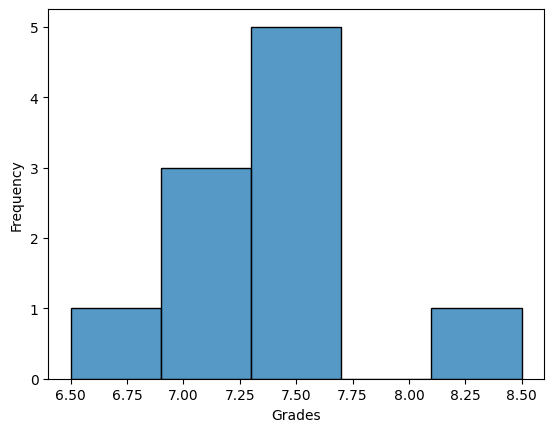

+---+-------+--------------------+----------------------------------+
| # | grade |       score        |             username             |
+---+-------+--------------------+----------------------------------+
| 0 |  7.5  | 0.7677777777777777 | 40be4d34cdfe43458f7986951475fe86 |
| 1 |  6.5  | 0.6316666666666666 | 785c2e122e974b92ae16f46082f6fcb1 |
| 2 |  7.5  | 0.7466666666666666 | d043cb8f94a341439443fa5100e49b25 |
| 3 |   7   | 0.7077777777777778 | 78e376a74a3c4f8f9d1d11f0c24b72de |
| 4 |  7.5  | 0.7577777777777778 | 6cad0ec157d34d87877e31afe1d4dd18 |
| 5 |   7   | 0.7066666666666667 | 54f90c6c68194b699281211c9f55b4d4 |
| 6 |  7.5  | 0.7677777777777777 | 3c59109b89e54276ab80861615995f43 |
| 7 |  8.5  | 0.8311111111111111 | 321a014c97d14484b9af0e51ef1a4f4c |
| 8 |  7.5  | 0.726111111111111  | 76dae5443a9749f9aa9db5e6e9b5f116 |
| 9 |   7   |        0.68        | 10c2d337d1dd4c19aa8e59e437cb3dda |
+---+-------+--------------------+----------------------------------+


In [7]:
output = report.calculate_grades(quiz_data, dst='output/grades.csv',
                                 figure='output/grades.png')
print(output)